In [1]:
!nvidia-smi

Sat Sep  7 16:12:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
%%capture
!pip install transformers==4.19.2
!pip install rouge_score

In [4]:
import pandas as pd
file_path = "wikihow.csv"
df = pd.read_csv(file_path, on_bad_lines='skip')
print(df.head())



                                               title  \
0  How to Remove Lint from Clothes: 14+ Easy Methods   
1  How to Remove Lint from Clothes: 14+ Easy Methods   
2  How to Remove Lint from Clothes: 14+ Easy Methods   
3  How to Remove Lint from Clothes: 14+ Easy Methods   
4  How to Remove Lint from Clothes: 14+ Easy Methods   

                                            heading  \
0                                Use a lint roller.   
1                      Make a homemade lint roller.   
2  Roll some wide, packaging tape around your hand.   
3                              Use a strip of tape.   
4                 Consider an electric lint shaver.   

                                           paragraph  
0  Use a lint roller. You can find them in the la...  
1  Make a homemade lint roller. You will need a r...  
2  Roll some wide, packaging tape around your han...  
3  Use a strip of tape. Find some wide tape, and ...  
4  Consider an electric lint shaver. This is a ba...  


In [5]:
df.shape

(3514, 3)

In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)


In [7]:
df['length'] = df.paragraph.map(lambda x: len(x.split(" ")))

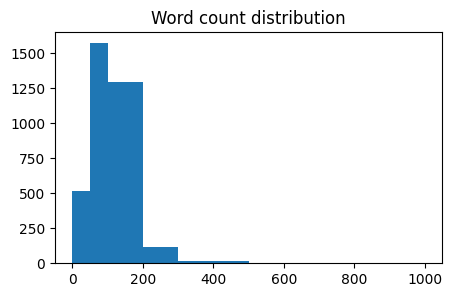

In [8]:

numOfWords = df.length
from matplotlib import pyplot as plt
# Creating plot
fig = plt.figure(figsize =(5, 3))
plt.hist(numOfWords.to_numpy(), bins = [0, 50, 100, 200, 300, 500, 1000])
plt.title("Word count distribution")
# show plot
plt.show()

In [9]:
tempDf = df[df.length <= 200]
tempDf.shape

(3375, 4)

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [11]:
max_input_length = 1024
max_output_length = 64
batch_size =16
def process_data_to_model_inputs(batch):
#tokenize the inputs and labels
  inputs =tokenizer(
  batch["paragraph"],
  padding="max_length",
  truncation=True,
  max_length=max_input_length,
  )
  outputs = tokenizer(
  batch["heading"],
  padding="max_length",
  truncation=True,
  max_length=max_output_length,
  )

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask



  batch["global_attention_mask"] = len(batch["input_ids"]) * [
    [0 for _ in range(len(batch["input_ids"][0]))]
  ]

  batch["global_attention_mask"][0][0] = 1
  batch["labels"] = outputs.input_ids



  batch["labels"] = [
    [-100 if token ==tokenizer.pad_token_id else token for token in labels]
    for labels in batch["labels"]
  ]
  return batch

In [12]:
import numpy as np
train, validate, test = np.split(tempDf.sample(frac=1, random_state=42), [int(.6*len (df)), int(.7*len (df))])
print(train.shape)
print(validate.shape)
print(test.shape)


(2103, 4)
(351, 4)
(921, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
validate=validate[:20]
validate.shape

(20, 4)

In [14]:
from datasets import Dataset
train_dataset = Dataset.from_pandas (train)
val_dataset = Dataset.from_pandas (validate)



In [15]:
print(train_dataset.column_names)



['title', 'heading', 'paragraph', 'length', '__index_level_0__']


In [16]:
train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"],
)


Map:   0%|          | 0/2103 [00:00<?, ? examples/s]

In [17]:
val_dataset = val_dataset.map(
process_data_to_model_inputs,
batched=True,
batch_size=batch_size,
remove_columns=["title", "heading", "paragraph", "length", "__index_level_0__"],
)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [18]:
train_dataset.set_format(
type="torch",
columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
type="torch",
columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],)

In [24]:
from transformers import AutoModelForSeq2SeqLM

from datasets import load_metric
# Load the Rouge metric
rouge = load_metric("rouge")

def compute_metrics(pred):
    # Ensure pred contains the necessary fields for evaluation
    # Example for ROUGE, assuming you have predictions and references
    predictions, references = pred
    return rouge.compute(predictions=predictions, references=references)

led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)
led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3


def compute_metrics (pred):
  labels_ids= pred.label_ids
  pred_ids =pred.predictions
  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids== -100] =tokenizer.pad_token_id
  label_str= tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
  rouge_output =rouge.compute(
  predictions=pred_str, references=label_str, rouge_types=["rouge2"]
  )["rouge2"].mid

  return {
  "rouge2_precision": round(rouge_output.precision, 4),
  "rouge2_recall": round(rouge_output.recall, 4), "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
  }
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()
training_args = Seq2SeqTrainingArguments(
predict_with_generate =True,
evaluation_strategy="steps",
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
output_dir="./",
logging_steps=5,
eval_steps=10,
save_steps=10,
save_total_limit=2,
gradient_accumulation_steps=4,
num_train_epochs=10
)

<ipython-input-24-288e1be59b9d>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


loading configuration file https://huggingface.co/allenai/led-base-16384/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ec844bead6f5bbcd6ac727b57e595c2ba40b0970f91cb923423773f72fe1702f.898baac75d55d484b1b1de95b8ab791987c78591acf36ce6131b56d0d2d26af7
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "gradient_checkpointing"

In [26]:
trainer= Seq2SeqTrainer(
model=led,
args=training_args,
train_dataset=train_dataset,
eval_dataset=val_dataset,
compute_metrics=compute_metrics,
)

In [28]:
trainer.train()

***** Running training *****
  Num examples = 2103
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 330


Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,0.023500,0.000750,0.837500,0.389300,0.481000


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-10
Configuration saved in ./checkpoint-10/config.json
Model weights saved in ./checkpoint-10/pytorch_model.bin
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,0.023500,0.000750,0.837500,0.389300,0.481000
20,0.019900,0.000394,0.890000,0.481800,0.579800
30,0.017000,0.003444,0.850000,0.409700,0.520800
40,0.022700,0.000852,0.850000,0.343400,0.450200
50,0.009100,0.000141,0.991700,0.951200,0.964300
60,0.011100,0.000303,0.990000,0.738900,0.796600
70,0.004100,0.000410,0.958300,0.830600,0.869200
80,0.005100,0.000432,1.000000,0.744400,0.807200
90,0.007100,0.000382,0.950000,0.547600,0.625500
100,0.004900,0.000210,0.995500,0.685500,0.754600


***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Saving model checkpoint to ./checkpoint-20
Configuration saved in ./checkpoint-20/config.json
Model weights saved in ./checkpoint-20/pytorch_model.bin
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore

KeyboardInterrupt: 

In [63]:
import pandas as pd
sample_paragraph = '''Extend your glove in front of you. Here's where hand-eye coordination comes into play. Extend your glove toward the ball, keeping your elbow slightly bent. Position your glove so that the ball will roll or hop right into it. A common mistake fielders make is not keeping their glove down. It is easier to bring the glove up than to get it down quickly, so keeping your glove in a low position provides better coverage.'''
data = [sample_paragraph]
df = pd.DataFrame(data, columns=['paragraph'])
df['paragraph'] [0]
from datasets import Dataset
df_test = Dataset.from_pandas(df)
df_test


Dataset({
    features: ['paragraph'],
    num_rows: 1
})

In [64]:
from datasets import load_metric
import torch
from datasets import load_dataset, load_metric
from transformers import LEDTokenizer, LEDForConditionalGeneration

#load tokenizer
tokenizer.save_pretrained("/content/checkpoint-100")
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-100")

model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-100").to("cuda").half()

def generate_answer(batch):
  inputs_dict = tokenizer(batch["paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
  input_ids= inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)
# put global attention on token
#
#global_attention_mask[:, 0] = 1
  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch["generated_heading"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch

result = df_test.map(generate_answer, batched=True, batch_size=2)

tokenizer config file saved in /content/checkpoint-100/tokenizer_config.json
Special tokens file saved in /content/checkpoint-100/special_tokens_map.json
Didn't find file /content/checkpoint-100/added_tokens.json. We won't load it.
loading file /content/checkpoint-100/vocab.json
loading file /content/checkpoint-100/merges.txt
loading file None
loading file /content/checkpoint-100/special_tokens_map.json
loading file /content/checkpoint-100/tokenizer_config.json
loading configuration file /content/checkpoint-100/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decode

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Input ids are automatically padded from 512 to 1024 to be a multiple of `config.attention_window`: 1024


In [65]:
result["generated_heading"]

['Extend your glove']